In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

Number Of Players    :  15
Number Of Images     :  576


Distribution Per Player


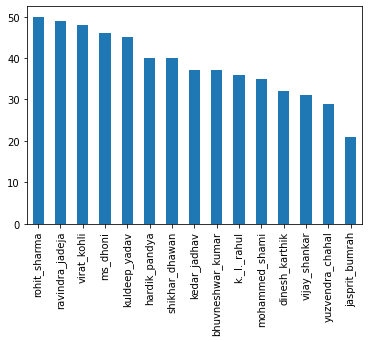

In [2]:
ds = pd.read_csv("C:/Users/ansug/OneDrive/Desktop/Internship_pending_task_21may/players.csv")
ds = ds.sample(frac=1).reset_index(drop=True)

le = preprocessing.LabelEncoder()
le.fit(ds['player'])
ds['player_trans'] = le.transform(ds['player'])

n = int(len(ds))
players = ds.player.nunique()
print("Number Of Players    : ",players)
print("Number Of Images     : ",n)
print("\n\nDistribution Per Player")
ds['player'].value_counts().plot.bar()

ds = ds[:-6]
test = ds[-6:]

Distribution Per Player


<AxesSubplot:>

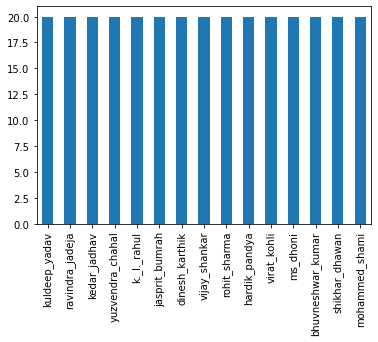

In [3]:
for index,row in ds.iterrows():
    if len(ds[ds['player']==row['player']])>20:
        ds.drop(ds[ds['image']==row['image']].index , inplace=True)

print("Distribution Per Player")
ds['player'].value_counts().plot.bar()

In [5]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:image = tf.image.transpose(image)
    if p_rotate > .75:image = tf.image.rot90(image, k=3) 
    elif p_rotate > .5:image = tf.image.rot90(image, k=2) 
    elif p_rotate > .25:image = tf.image.rot90(image, k=1) 

    if p_pixel_1 >= .4:image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:image = tf.image.random_brightness(image, max_delta=.1)

    if p_crop > .7:
        if p_crop > .9:image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:image = tf.image.central_crop(image, central_fraction=.8)
        else:image = tf.image.central_crop(image, central_fraction=.9)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(224*.8),224, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
    
    image = tf.image.resize(image, [224,224])
    return image,label

def load_img(image,player,player_transf):
    path = "C:/Users/ansug/OneDrive/Desktop/Internship_pending_task_21may/images/"+player+"/"+image
    img = tf.io.decode_jpeg(tf.io.read_file(path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img,player_transf
dataset = tf.data.Dataset.from_tensor_slices((ds.image.values,ds.player.values,ds.player_trans.values))

In [6]:
train_ds = dataset.take(int(0.8*n))
val_ds = dataset.skip(int(0.8*n))
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(load_img,num_parallel_calls=AUTOTUNE)
train_ds = train_ds.repeat(40).map(data_augment,num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(32).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(load_img,num_parallel_calls=AUTOTUNE).batch(32).prefetch(buffer_size=AUTOTUNE)

In [7]:
base_model = keras.applications.MobileNetV2(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(players, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

9412608/9406464 [==============================] - 1s 0us/step


In [9]:
checkpoint_path = "./checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

In [10]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
history = model.fit(train_ds, epochs=20, validation_data=val_ds,verbose=1,callbacks=[cp_callback])

Epoch 1/20
375/375 [==============================] - 590s 2s/step - loss: 1.4765 - accuracy: 0.5717

Epoch 00001: saving model to ./checkpoints\cp.ckpt
Epoch 2/20
375/375 [==============================] - 650s 2s/step - loss: 0.6379 - accuracy: 0.8568

Epoch 00002: saving model to ./checkpoints\cp.ckpt
Epoch 3/20
375/375 [==============================] - 786s 2s/step - loss: 0.4018 - accuracy: 0.9219

Epoch 00003: saving model to ./checkpoints\cp.ckpt
Epoch 4/20
375/375 [==============================] - 719s 2s/step - loss: 0.2943 - accuracy: 0.9508

Epoch 00004: saving model to ./checkpoints\cp.ckpt
Epoch 5/20
375/375 [==============================] - 253s 676ms/step - loss: 0.2316 - accuracy: 0.9641

Epoch 00005: saving model to ./checkpoints\cp.ckpt
Epoch 6/20
375/375 [==============================] - 232s 618ms/step - loss: 0.1818 - accuracy: 0.9729

Epoch 00006: saving model to ./checkpoints\cp.ckpt
Epoch 7/20
375/375 [==============================] - 232s 619ms/step - loss

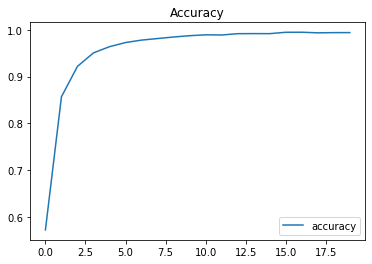

In [11]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history)[['accuracy']].plot()
plt.title("Accuracy")
plt.show()

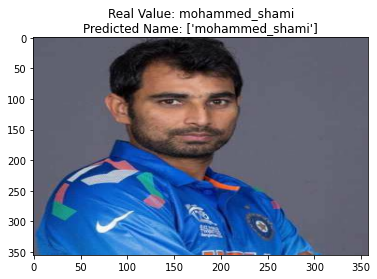

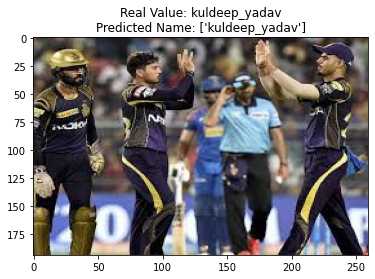

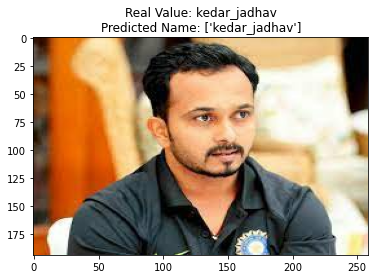

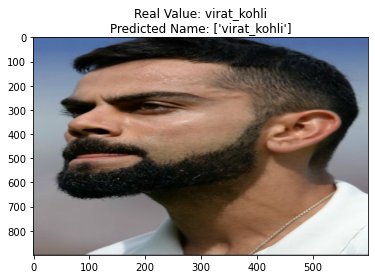

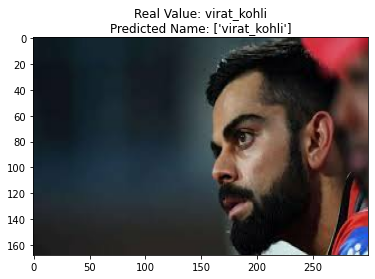

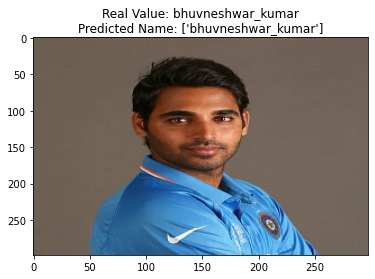

In [16]:
i=0
def load_test_img(image,player,player_transf):
    path = "C:/Users/ansug/OneDrive/Desktop/Internship_pending_task_21may/images/"+player+"/"+image
    img = tf.io.decode_jpeg(tf.io.read_file(path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img
test_ds = tf.data.Dataset.from_tensor_slices((test.image.values,test.player.values,test.player_trans.values))
test_ds = test_ds.map(load_test_img).batch(6)
prediction = model.predict(test_ds)

for index,row in test.iterrows():
    img = tf.io.decode_jpeg(tf.io.read_file("C:/Users/ansug/OneDrive/Desktop/Internship_pending_task_21may/images/"+row['player']+"/"+row['image']),channels=3)
    imgplot = plt.imshow(img.numpy().astype("uint8"),aspect='auto')
    real = str(list(le.classes_)[row['player_trans']])
    top_k_values, top_k_indices = tf.nn.top_k(prediction[i], k=3)
    top_k_names = []
    for k in range(1):
        top_k_names+=[str(list(le.classes_)[top_k_indices[k]])]
    plt.title("Real Value: "+str(real)+"\nPredicted Name: "+str(top_k_names))
    plt.show()
    i+=1